In [1]:
!conda install -y -c conda-forge scikit-surprise

Solving environment: ...working... done

# All requested packages already installed.



In [15]:
# Розробимо за допомогою бібліотеки surprise рекомендаційну систему. Використовуємо датасет movielens-100k.
from surprise import Dataset, Reader,SVD,SVDpp,NMF,SlopeOne,KNNBasic
from surprise.model_selection import cross_validate
import matplotlib.pyplot as plt
data = Dataset.load_builtin('ml-100k')
# data.head()

In [3]:
# Використовуємо алгоритми SVD, SVDpp, NMF + ще два на власний вибір. Найкращі параметри для всіх алгоритмів підбираємо за допомогою крос-валідації.
algo_svd = SVD()
algo_svdpp = SVDpp()
algo_NMF = NMF()
algo_slop = SlopeOne()
algo_KNN = KNNBasic()

In [4]:
# Крос-валідація використовується для оцінки того, наскільки добре ці алгоритми працюють на вашому датасеті.
crossval_svd = cross_validate(algo_svd,data,measures=['RMSE'], cv = 3, verbose=True)
crossval_svdpp = cross_validate(algo_svdpp,data,measures=['RMSE'], cv = 3, verbose=True)
crossval_NMF = cross_validate(algo_NMF,data,measures=['RMSE'], cv = 3, verbose=True)
crossval_slop = cross_validate(algo_slop,data,measures=['RMSE'], cv = 3, verbose=True)
crossval_KNN = cross_validate(algo_KNN,data,measures=['RMSE'], cv = 3, verbose=True)

Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9455  0.9450  0.9419  0.9441  0.0016  
Fit time          0.65    0.67    0.65    0.65    0.01    
Test time         0.18    0.18    0.18    0.18    0.00    
Evaluating RMSE of algorithm SVDpp on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9243  0.9278  0.9315  0.9279  0.0030  
Fit time          9.27    9.22    9.27    9.25    0.03    
Test time         4.71    4.70    4.60    4.67    0.05    
Evaluating RMSE of algorithm NMF on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9718  0.9782  0.9699  0.9733  0.0035  
Fit time          1.18    1.20    1.20    1.20    0.01    
Test time         0.22    0.22    0.22    0.22    0.00    
Evaluating RMSE of algorithm SlopeOne on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9503  0.94

In [5]:
# Обчислимо середнє значення середньоквадратичної помилки RMSE для кожного алгоритму на основі результатів крос-валідації
rmse_svd = crossval_svd['test_rmse'].mean()
rmse_svdpp = crossval_svdpp['test_rmse'].mean()
rmse_NMF = crossval_NMF['test_rmse'].mean()
rmse_slop = crossval_slop['test_rmse'].mean()
rmse_KNN = crossval_KNN['test_rmse'].mean()
print(f"svd:{rmse_svd}")
print(f"svdpp:{rmse_svdpp}")
print(f"nmf:{rmse_NMF}")
print(f"slope:{rmse_slop}")
print(f"knn:{rmse_KNN}")

svd:0.9441332129925862
svdpp:0.9278627433667204
nmf:0.9733211256132576
slope:0.9490953854782097
knn:0.9892646008289837


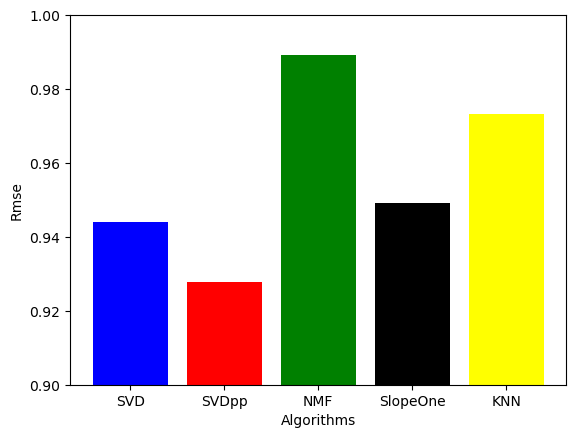

In [6]:
# Візуалізація даних
rmse_vals = [rmse_svd,rmse_svdpp,rmse_KNN,rmse_slop,rmse_NMF]
algorithms = ['SVD','SVDpp','NMF','SlopeOne','KNN']
plt.bar(algorithms,rmse_vals,color=['blue','red','green','black','yellow'])
plt.xlabel('Algorithms')
plt.ylabel('Rmse')
plt.ylim(0.9,1.0)
plt.show()

In [7]:
# Працюємо з алгоритмом SCDpp,також проводимо поділ набору даних.
from surprise import accuracy
from sklearn.metrics import mean_absolute_error
from surprise.model_selection import train_test_split
trainset, testset = train_test_split(data, test_size=.25)
algo_svdpp.fit(trainset)
predictions = algo_svdpp.test(testset)
accuracy.rmse(predictions)

RMSE: 0.9212


0.9211910161471097

In [8]:
from surprise.model_selection import GridSearchCV
param_grid = {'n_epochs': [5, 10], 'lr_all': [0.002, 0.005],
              'reg_all': [0.4, 0.6]}
gs = GridSearchCV(SVDpp, param_grid, measures=['rmse', 'mae'], cv=3)
gs.fit(data)
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

0.9642751374427786
{'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}


In [9]:
# Імпортуємо токен з сайту
!pip install sigopt
from sigopt import Connection
conn = Connection(client_token="FQAJHXQJZHLSLFODVJXEHAHFYLGPSNBDSEPXNPAULUGNECQE")

Тепер визначаемо параметри

In [10]:
# Тепер визначаемо параметри
experiment = conn.experiments().create(
  name='Surprise Movies-100k Recommender41',
  parameters=[
    dict(name='n_epochs', type='int', bounds=dict(min=5, max=10)),
    dict(name='lr_all', type='double', bounds=dict(min=0.002, max=0.005)),
    dict(name='reg_all', type='double', bounds=dict(min=0.4, max=0.6))
  ],
  metrics=[
    dict(name='RMSE', objective='minimize', strategy='optimize'),
    dict(name='MAE', objective='minimize', strategy='store')
  ],
  parallel_bandwidth=1,
  observation_budget=50,
)
print("Created experiment: https://app.sigopt.com/experiment/" + experiment.id)

Created experiment: https://app.sigopt.com/experiment/1023679


In [11]:
# Визначаємо функції, які необхідні для створення моделі
def create_model(assignments):
  algo = SVDpp(
      n_epochs=assignments['n_epochs'],
      lr_all=assignments['lr_all'],
      reg_all=assignments['reg_all']
  ).fit(trainset)
  return algo

def evaluate_model(assignments):
  algo = create_model(assignments)
  predictions = algo.test(testset)
  return [
      dict(name="RMSE", value=accuracy.rmse(predictions)),
      dict(name="MAE", value=accuracy.mae(predictions))
    ]

In [12]:
# Цикл оптимізації
while experiment.progress.observation_count < experiment.observation_budget:
  suggestion = conn.experiments(experiment.id).suggestions().create()
  value_dicts = evaluate_model(suggestion.assignments)
  conn.experiments(experiment.id).observations().create(
    suggestion=suggestion.id,
    values=value_dicts,
  )

  experiment = conn.experiments(experiment.id).fetch()

# Fetch the best configuration and explore your experiment
all_best_assignments = conn.experiments(experiment.id).best_assignments().fetch()
# Returns a list of dict-like Observation objects
best_assignments = all_best_assignments.data[0].assignments
print("Best Assignments: " + str(best_assignments))
print("Explore your experiment: https://app.sigopt.com/experiment/" + experiment.id + "/analysis")

RMSE: 0.9766
MAE:  0.7888
RMSE: 0.9749
MAE:  0.7864
RMSE: 0.9633
MAE:  0.7744
RMSE: 0.9782
MAE:  0.7890
RMSE: 0.9601
MAE:  0.7710
RMSE: 0.9629
MAE:  0.7742
RMSE: 0.9625
MAE:  0.7732
RMSE: 0.9602
MAE:  0.7711
RMSE: 0.9600
MAE:  0.7709
RMSE: 0.9789
MAE:  0.7896
RMSE: 0.9673
MAE:  0.7790
RMSE: 0.9605
MAE:  0.7717
RMSE: 0.9689
MAE:  0.7797
RMSE: 0.9666
MAE:  0.7786
RMSE: 0.9616
MAE:  0.7725
RMSE: 0.9708
MAE:  0.7829
RMSE: 0.9670
MAE:  0.7778
RMSE: 0.9596
MAE:  0.7706
RMSE: 0.9675
MAE:  0.7785
RMSE: 0.9835
MAE:  0.7946
RMSE: 0.9654
MAE:  0.7759
RMSE: 0.9699
MAE:  0.7806
RMSE: 0.9783
MAE:  0.7891
RMSE: 0.9680
MAE:  0.7801
RMSE: 0.9667
MAE:  0.7785
RMSE: 0.9734
MAE:  0.7842
RMSE: 0.9765
MAE:  0.7883
RMSE: 0.9739
MAE:  0.7854
RMSE: 0.9685
MAE:  0.7804
RMSE: 0.9720
MAE:  0.7844
RMSE: 0.9782
MAE:  0.7892
RMSE: 0.9781
MAE:  0.7894
RMSE: 0.9703
MAE:  0.7807
RMSE: 0.9802
MAE:  0.7922
RMSE: 0.9624
MAE:  0.7733
RMSE: 0.9724
MAE:  0.7845
RMSE: 0.9711
MAE:  0.7820
RMSE: 0.9635
MAE:  0.7742
RMSE: 0.9657

C:\Users\lazar\anaconda3\Lib\site-packages\sigopt\objects.py:338: RuntimeWarning: The .data field only contains a single page of results, which may be incomplete for large responses. Prefer to use the `.iterate_pages() to ensure that you iterate through all elements in the response.
  warnings.warn(


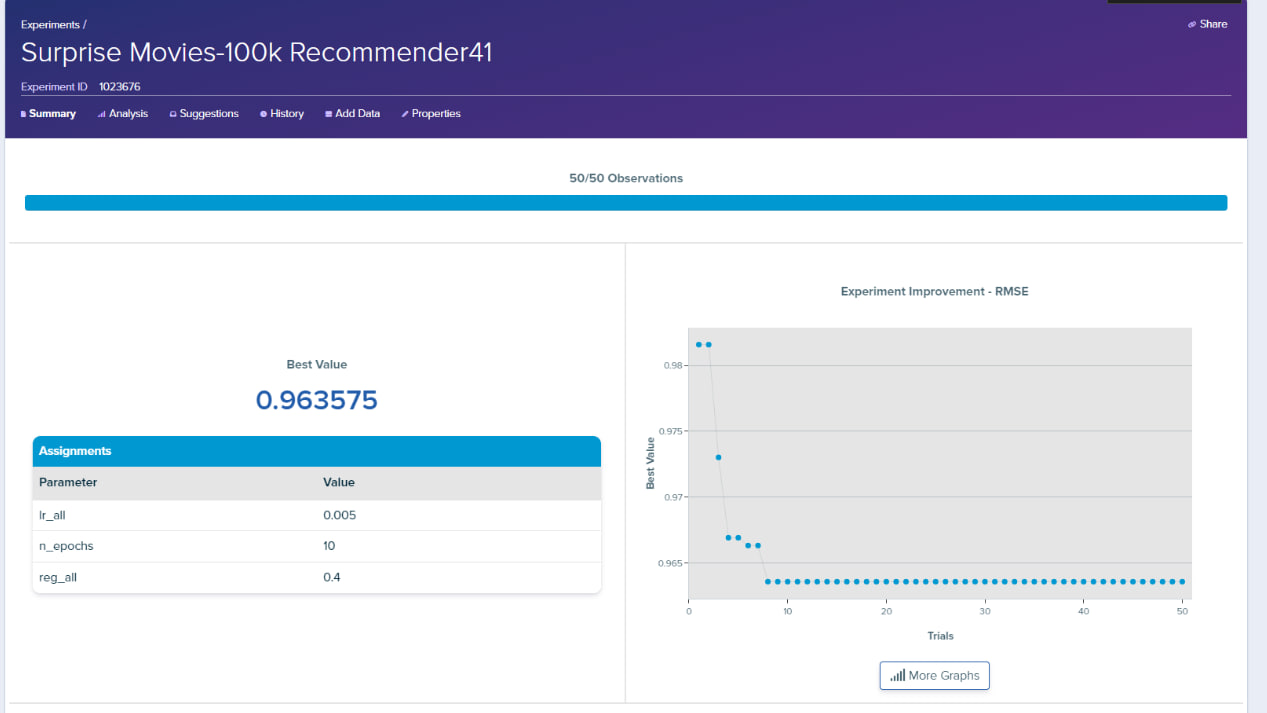

Отже, я розробив рекомендаційну систему за допомогою бібліотеки surprise, використовуючи датасет movielens-100k. Використовув алгоритми: SVD, SVDpp, NMF, SlopeOne, KNN. Параметри підібрав за допомогою крос-валідації. Обчислив середнє значення ередньоквадратичної помилки RMSE для кожного алгоритму на основі результатів крос-валідації. 